In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from matplotlib.colors import LogNorm
from scipy.interpolate import RectBivariateSpline

import quasiclassical_solver as qs
from legendre import *

In [2]:
au2cm = 219474.63
au2ps = 2.4188843265864e-5
au2eV = 27.2
au2A = 0.529177
Db2au = 0.393456
u2au = 1822.88839

# Potential

7 47
0.2164


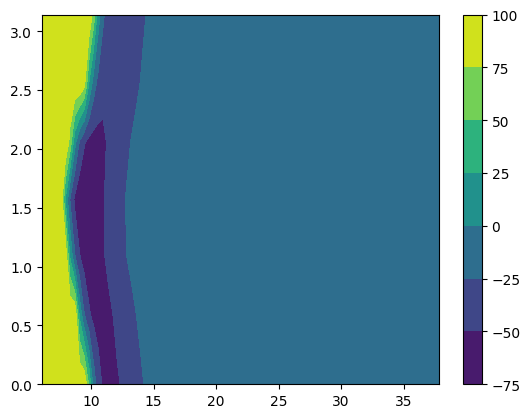

In [3]:
data = np.loadtxt( "../potentials/potential.dat" )


th_raw = np.array([0.0, 33.8783, 62.0404, 90.0, 117.96, 146.122, 180.0]) * np.pi / 180.

N_th = len(th_raw)
N_R = len( data ) // N_th

print( N_th, N_R )

R_raw = data[:N_R, 0]

PES_raw = np.reshape( data[:,1], (N_th, N_R) )


print( np.max( PES_raw ) )

PES_clip = np.clip(PES_raw * au2cm, -100, 100)
R_gr, th_gr = np.meshgrid( R_raw, th_raw )

plt.contourf( R_gr, th_gr, PES_clip )
plt.colorbar()

pass

/tmp/ipykernel_373578/184471368.py:46: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf( R_ext, th_raw, np.abs(PES_ext) * au2cm, norm=LogNorm() )


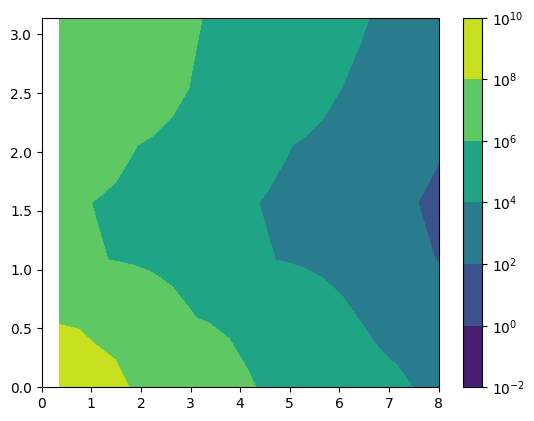

In [253]:
def extrapolate_to_zero(rs, V_values, max_val=1000):
    dr = rs[1] - rs[0]
    dVRatio = V_values[0] / V_values[1]
    dVRatio *= 1.005

    rs_extended = [rs[0] - dr]
    V_extended = [V_values[0] * dVRatio]

    dumping = 0
    while rs_extended[-1] > dr:
        if V_extended[-1] >= max_val:
            V_extended[-1] = max_val + 1000 * np.sqrt(dumping)
            dVRatio = 1
            dumping += 1
        else:
            dVRatio *= 1.005
        rs_extended.append(rs_extended[-1] - dr)
        V_extended.append(V_extended[-1] * dVRatio)

    rs_extended.reverse()
    V_extended.reverse()

    return rs_extended, V_extended

def extrapolate_to_infinity(rs, V_values, max_distance = 60):
    dr = rs[-1] - rs[-2]
    r_extended = [rs[-1] + dr]
    V_extended = [0.0]
    while(r_extended[-1] < max_distance):
        r_extended.append(r_extended[-1] + dr)
        V_extended.append(0.0)

    return r_extended, V_extended

PES_ext = [[]]*N_th

for i in range(N_th):
    R_ext_0, PES_ext_0 = extrapolate_to_zero(R_raw, PES_raw[i])
    R_ext_inf, PES_ext_inf = extrapolate_to_infinity(R_raw, PES_raw[i], max_distance = 50.)
    R_ext = R_ext_0 + list( R_raw ) + R_ext_inf
    PES_ext[i] = PES_ext_0 + list( PES_raw[i] ) + PES_ext_inf

R_ext = np.array( R_ext )
PES_ext = np.array( PES_ext )

plt.contourf( R_ext, th_raw, np.abs(PES_ext) * au2cm, norm=LogNorm() )

plt.xlim( 0, 8 )

plt.colorbar()

pass

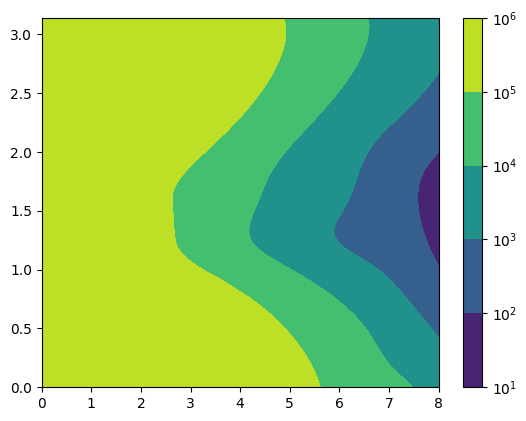

In [257]:
V_interp = RectBivariateSpline( th_raw, R_ext, PES_ext, kx=5, ky=5, s=0 )


force = V_interp.partial_derivative(0, 1)
force_vect = np.vectorize( lambda r, th: - force( th, r ) )

def potential( r, th ):
    return V_interp( th, r )

potential = np.vectorize( potential )


r_arr = np.linspace( 0, 8, 300 )
th_arr = np.linspace( 0, np.pi, 300 )


th_gr, r_gr = np.meshgrid( th_arr, r_arr )

PES_interp = potential( r_gr, th_gr )
PES_clip = np.clip(PES_interp * au2cm, 0, 1 * au2cm)

plt.contourf( r_gr, th_gr, np.abs(PES_clip), norm=LogNorm() )
plt.colorbar()


# Simulation

In [215]:
solv = qs.Quasi_classic( m_rot = (16 + 32 + 12) * u2au, 
                        Be_rot = 0.20286/au2cm,#9.243165268327e-7, 
                        m_proj = 20 * u2au 
                        )

# simple_pot = lambda r, th: 2.5e7 / r**12 - 100/r**6 * ( 1 + 3 * np.cos( th )**2 + np.cos( th )**3 + np.cos( th )**10 )
solv.set_potential( potential )
solv.set_force( force_vect )

j_init = 0
solv.set_hilbert_space( max_l=300, 
                       max_m = j_init
                       )

solv.set_initial_conditions( E_col = 3700 * 3.1668105e-6, 
                            r_0 = 30.0, 
                            l_0 = j_init 
                            )

solv.solve( t_max = 2 / au2ps,
           kwargs={"first_step": 1e3,
                   "atol": 1e-7, "rtol": 1e-5}
           ) 

print( f"j_init={j_init} finished" )

pass

j_init=0 finished


# Plotting

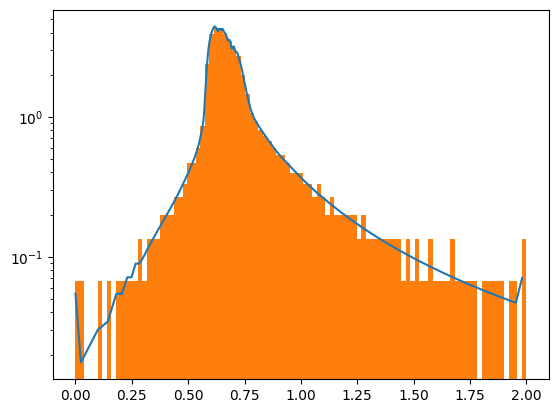

In [227]:
plt.plot( solv.t[:-1] * au2ps ,  1. / np.diff( solv.t ) / au2ps / solv.N_t )
plt.hist( solv.t * au2ps, bins = 101, density=True )

# plt.plot( solv.t[:-1] * au2ps ,  np.diff( solv.t ) )

plt.semilogy()

pass

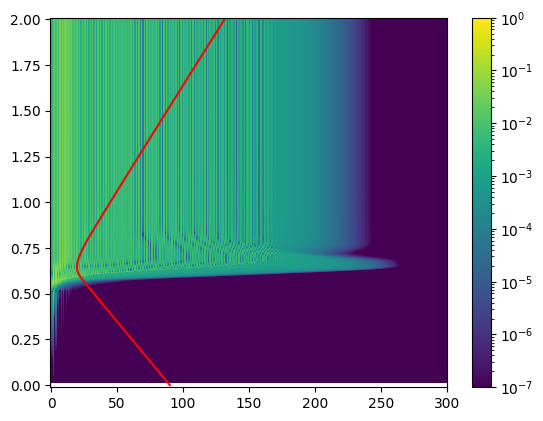

In [222]:
l_max = np.max( solv.l_arr )
rot_prob = np.zeros( (solv.N_t, l_max + 1) )

for i, l in enumerate( solv.l_arr ):
    rot_prob[:, l] += np.abs( solv.Psi[:, i] )**2

# rot_prob = rot_prob / np.reshape( np.max( rot_prob, axis=1 ), (-1,1) )

plt.pcolor(np.arange( 0, l_max + 1 ), 
           solv.t*au2ps,           
           rot_prob, norm=LogNorm(vmin = 1e-7) )

plt.colorbar()

# plt.xlim( -0.5, 50 )

# plt.ylim( 1., 1.25 )

plt.plot( solv.r*3, solv.t*au2ps, 'r' )

pass

0.655656685785372


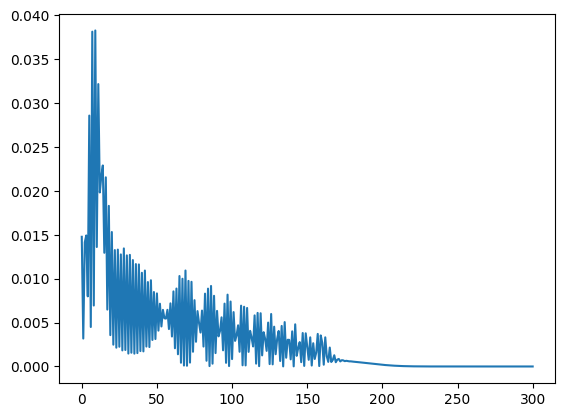

In [223]:
plt.plot( np.arange( l_max + 1 ), rot_prob[-1,:] )
# plt.semilogy()
print( np.sum( rot_prob[-1,20:] ) )

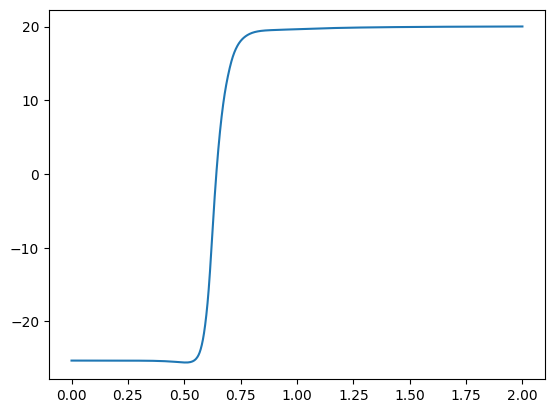

In [57]:
plt.plot( solv.t * au2ps, solv.p )
# plt.xlim( 0, 2 )
# plt.ylim( 0, 50 )